<a href="https://colab.research.google.com/github/D0m-inic/NLP_CW/blob/main/NLP_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import torch
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from ast import literal_eval

# Helper Functions + Setup

In [ ]:
# Prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# Check GPU
!nvidia-smi

cuda_available = torch.cuda.is_available()

print('Cuda available?', cuda_available)

Mon Mar  3 17:54:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
if cuda_available:
  import tensorflow as tf
  device = 'cuda'
  # Get the GPU device name
  device_name = tf.test.gpu_device_name()

  # The device name should look like the following:
  if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')
else:
   device = 'cpu'

Found GPU at: /device:GPU:0


In [ ]:
# Save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')


# Fetch Official Datasets + Splits

In [ ]:
import os

# MARK: Clone updated dataset
if not os.path.exists('augmented_dataset.csv'):
  !wget -q -O augmented_dataset_substitution.csv "https://raw.githubusercontent.com/D0m-inic/NLP_CW/refs/heads/main/positive_augmented_2x.csv"

if not os.path.exists('augmented_dataset_back_translation.csv'):
  !wget -q -O augmented_dataset_back_translation.csv "https://raw.githubusercontent.com/D0m-inic/NLP_CW/refs/heads/main/positive_augmented_back_translation.csv"

# Clone Task 1 dataset
if not os.path.exists('dontpatronizeme_pcl.tsv'):
  !wget -q -O dontpatronizeme_pcl.tsv "https://raw.githubusercontent.com/CRLala/NLPLabs-2024/refs/heads/main/Dont_Patronize_Me_Trainingset/dontpatronizeme_pcl.tsv"

# Clone Task 2 dataset
if not os.path.exists('dontpatronizeme_categories.tsv'):
  !wget -q -O dontpatronizeme_categories.tsv "https://raw.githubusercontent.com/CRLala/NLPLabs-2024/refs/heads/main/Dont_Patronize_Me_Trainingset/dontpatronizeme_categories.tsv"

# Clone Testing set with no Labels
if not os.path.exists('dontpatronizeme_test.tsv'):
  !wget -q -O dontpatronizeme_test.tsv "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/refs/heads/master/semeval-2022/TEST/task4_test.tsv"

# Clone dev set labels: `dev_semeval_parids-labels.csv`
if not os.path.exists('dev_semeval_parids-labels.csv'):
  !wget -q -O dev_semeval_parids-labels.csv "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv"

# Clone train set labels: `train_semeval_parids-labels.csv`
if not os.path.exists('train_semeval_parids-labels.csv'):
  !wget -q -O train_semeval_parids-labels.csv "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/refs/heads/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv"

# Fetch the data loader from original author
if not os.path.exists('dont_patronize_me.py'):
  !wget -q -O dont_patronize_me.py "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"

In [ ]:
from dont_patronize_me import DontPatronizeMe

In [ ]:
dpm = DontPatronizeMe('.', '.')
dpm.load_task1()
dpm.load_task2(return_one_hot=True)

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


# Load Official Splits

In [ ]:
# Load practice splits for official train and dev sets
trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')

trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

In [ ]:
# Load official splits into memory
train_df = dpm.train_task1_df[dpm.train_task1_df['par_id'].isin(trids.par_id)] # Official Train
official_dev_df = dpm.train_task1_df[dpm.train_task1_df['par_id'].isin(teids.par_id)] # Official Validation

print("Official Training Set size:", train_df.shape)
print("Official Dev Set size:", official_dev_df.shape)

Official Training Set size: (8375, 7)
Official Dev Set size: (2094, 7)


## Training / Validation Splits

In [ ]:
# Split the official training set into internal training and internal validation
from sklearn.model_selection import train_test_split

validation_ratio = 0.2
internal_train_df, internal_val_df = train_test_split(train_df, test_size=validation_ratio, random_state=42, stratify=train_df['label'])

print("Internal Training Set size:", internal_train_df.shape)
print("Internal Validation Set size:", internal_val_df.shape)

Internal Training Set size: (6700, 7)
Internal Validation Set size: (1675, 7)




# Rebuild DataFrames with Standardised Columns

In [ ]:
def standardise_columns(df, include_label=True):
  """
  Select the desired columns and rename 'keyword' to 'community'
  include_label is False => 'label' column is omitted
  """
  if include_label:
      new_df = df[['par_id', 'keyword', 'text', 'label', 'orig_label']].copy()
      new_df = new_df.rename(columns={'keyword': 'community'})
  else:
      # For cases where no label is available (e.g. test set)
      new_df = df[['par_id', 'keyword', 'text']].copy()
      new_df = new_df.rename(columns={'keyword': 'community'})
  return new_df

In [ ]:
# Standardise the internal training and validation sets.
internal_train_df = standardise_columns(internal_train_df, include_label=True)
internal_val_df   = standardise_columns(internal_val_df, include_label=True)
internal_test_df = standardise_columns(official_dev_df, include_label=True)

#### Load Augmented Dataset

In [ ]:
# augmented_train_set = pd.read_csv('augmented_dataset_substitution.csv')
augmented_train_set = pd.read_csv('augmented_dataset_back_translation.csv')
augmented_train_set = augmented_train_set.sample(frac=1, random_state=42).reset_index(drop=True)
augmented_train_set
print(f"Class Distribution - Original: {internal_train_df['label'].value_counts()}\n")
print(f"Class Distribution - Augmented: {augmented_train_set['label'].value_counts()}\n")

Class Distribution - Original: label
0    6065
1     635
Name: count, dtype: int64

Class Distribution - Augmented: label
0    6065
1    1270
Name: count, dtype: int64



## Build Evaluation Test DataFrame

In [ ]:
test_rows = []
with open('dontpatronizeme_test.tsv', encoding='utf-8') as f:
    # Skip the header lines (assumes the first 4 lines are headers)
    lines = f.readlines()[4:]
    for line in lines:
        parts = line.strip().split('\t')
        if len(parts) < 5:
            print("Warning: unexpected line format:", line)
            continue
        par_id, art_id, keyword, country, text = parts[:5]
        test_rows.append({
            'par_id': par_id,
            # 'art_id': art_id,
            'keyword': keyword,
            # 'country': country,
            'text': text
        })

test_df = pd.DataFrame(test_rows)
official_test_df = standardise_columns(test_df, include_label=False)

## TextDataset (add 10/02)

In [ ]:
from torch.utils.data import Dataset

# Custom class for handling input data - prepares text and labels to be fed into model

class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=512, label_column='label'):
        self.text = df['text'].tolist()
        self.labels = df[label_column].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        encoding = self.tokenizer(
            self.text[index],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
        )

        item = {k: torch.tensor(v) for k, v in encoding.items()}
        item['labels'] = torch.tensor(self.labels[index], dtype=torch.long)

        return item


# Data Analysis


## Frequency Analysis

In [ ]:
data = pd.concat([official_dev_df, train_df])
print(data.keys())

Index(['par_id', 'art_id', 'keyword', 'country', 'text', 'label',
       'orig_label'],
      dtype='object')


Label counts (0 = negative, 1 = positive):
label
0    7581
1     794
Name: count, dtype: int64


<ipython-input-17-012c1c2822eb>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


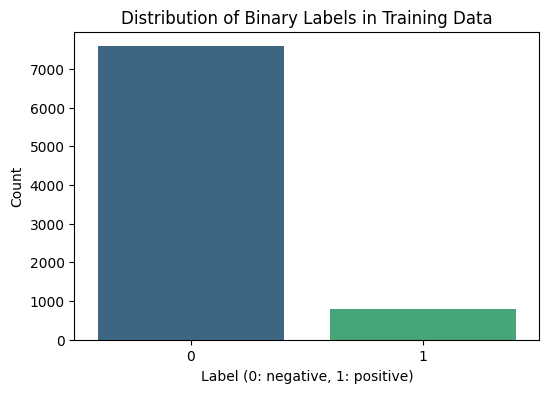

In [ ]:
label_counts = train_df['label'].value_counts().sort_index()

print("Label counts (0 = negative, 1 = positive):")
print(label_counts)

# Visualisation
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.xlabel("Label (0: negative, 1: positive)")
plt.ylabel("Count")
plt.title("Distribution of Binary Labels in Training Data")
plt.show()

## Input Length Analysis

<ipython-input-18-c9b499b2e5f7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))
<ipython-input-18-c9b499b2e5f7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  official_dev_df['text_length'] = official_dev_df['text'].apply(lambda x: len(x.split()))


Text Legnth Statistics by Label:
        count       mean        std  min   25%   50%   75%    max
label                                                            
0      7581.0  48.167656  29.183814  1.0  30.0  42.0  59.0  909.0
1       794.0  53.521411  33.673945  6.0  33.0  47.0  66.0  512.0


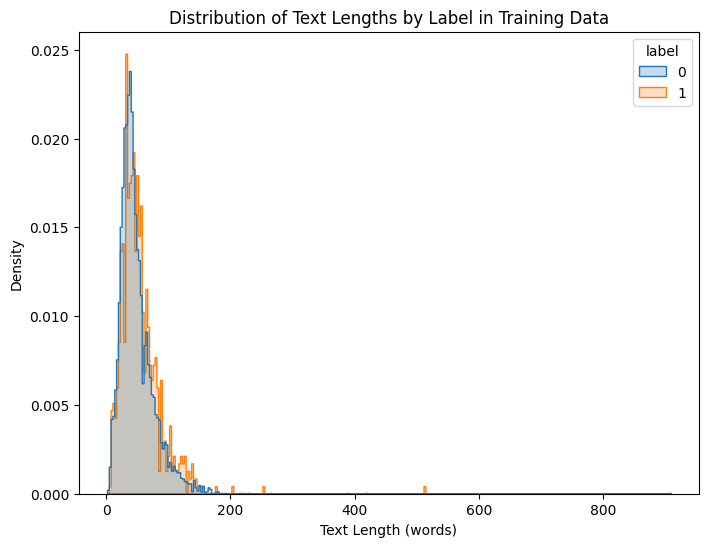

In [ ]:
# Add new column for length of each text entry. Split on whitespace (assumption - should tokenize)
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))
official_dev_df['text_length'] = official_dev_df['text'].apply(lambda x: len(x.split()))

length_stats = train_df.groupby('label')['text_length'].describe()
print("Text Legnth Statistics by Label:")
print(length_stats)

# Visualisation
plt.figure(figsize=(8,6))
sns.histplot(data=train_df, x="text_length", hue="label", element="step", stat="density", common_norm=False)
plt.xlabel("Text Length (words)")
plt.title("Distribution of Text Lengths by Label in Training Data")
plt.show()

In [ ]:
# Display breakdown of P/N per community
community_label_counts = (
    data.groupby(['keyword', 'label'])
        .size()
        # .reset_index(name='count')
)

# Group by community (keyword) and label to get the counts
community_label_counts = data.groupby(['keyword', 'label']).size()

# Convert the Series to a DataFrame for easier manipulation
community_label_counts_df = community_label_counts.reset_index(name='count')

# Pivot the DataFrame so that each community is a row and label counts are in columns.
# Fill missing values with 0 (in case a community doesn't have any examples of a given label)
pivot_df = community_label_counts_df.pivot(index='keyword', columns='label', values='count').fillna(0)

# For clarity, rename the columns if desired:
pivot_df = pivot_df.rename(columns={0: 'Negative', 1: 'Positive'})

# Calculate the total number of examples per community
pivot_df['Total'] = pivot_df.sum(axis=1)

# Calculate the ratios (i.e., the fraction of examples that are negative or positive)
pivot_df['Ratio_Negative'] = pivot_df['Negative'] / pivot_df['Total']
pivot_df['Ratio_Positive'] = pivot_df['Positive'] / pivot_df['Total']

# Print out the ratios per community
print(pivot_df[['Ratio_Negative', 'Ratio_Positive']])


label          Ratio_Negative  Ratio_Positive
keyword                                      
disabled             0.921206        0.078794
homeless             0.834726        0.165274
hopeless             0.876617        0.123383
immigrant            0.971725        0.028275
in-need              0.837338        0.162662
migrant              0.966942        0.033058
poor-families        0.834983        0.165017
refugee              0.919476        0.080524
vulnerable           0.925926        0.074074
women                0.951402        0.048598


In [ ]:
task2_df = dpm.train_task2_df

print("Task 2 DataFrame shape:", task2_df.shape)

Task 2 DataFrame shape: (993, 6)


## Frequency of each category

Frequency of each Task 2 category:
Unbalanced_power_relations    716
Compassion                    469
Authority_voice               230
Presupposition                224
Metaphors                     197
Shallow_solution              196
The_poorer_the_merrier         40
dtype: int64


<ipython-input-21-9e429448f0a2>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="magma")


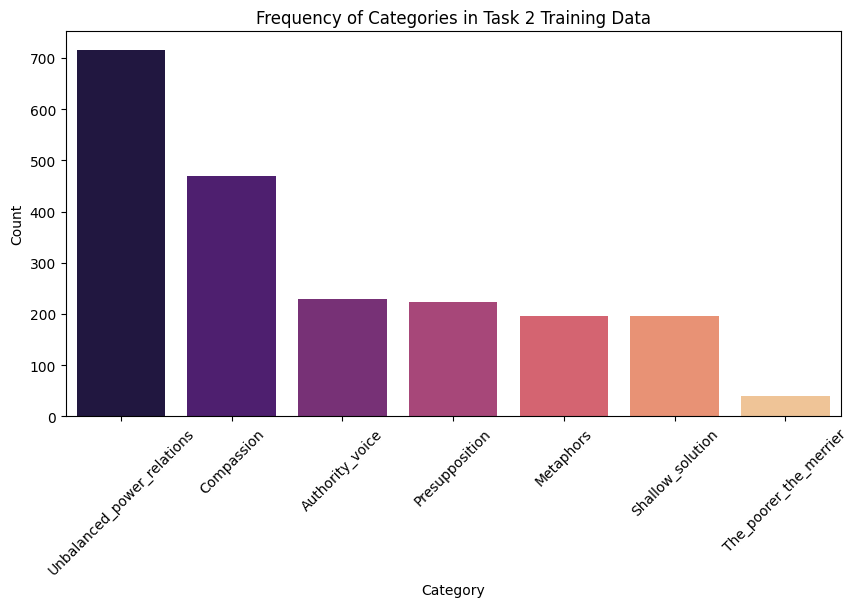

In [ ]:
categories = ['Unbalanced_power_relations', 'Shallow_solution', 'Presupposition',
              'Authority_voice', 'Metaphors', 'Compassion', 'The_poorer_the_merrier']

labels_array = np.array(task2_df['label'].tolist())
labels_df = pd.DataFrame(labels_array, columns=categories)

category_counts = labels_df.sum().sort_values(ascending=False)
print("Frequency of each Task 2 category:")
print(category_counts)

# Plot category frequencies
plt.figure(figsize=(10,5))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="magma")
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Frequency of Categories in Task 2 Training Data")
plt.xticks(rotation=45)
plt.show()

## Categories per example

Summary statistics for the number of categories per example:
count    993.000000
mean       2.086606
std        0.940011
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: num_categories, dtype: float64


<ipython-input-22-64099f0642fa>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=task2_df['num_categories'], palette="coolwarm")


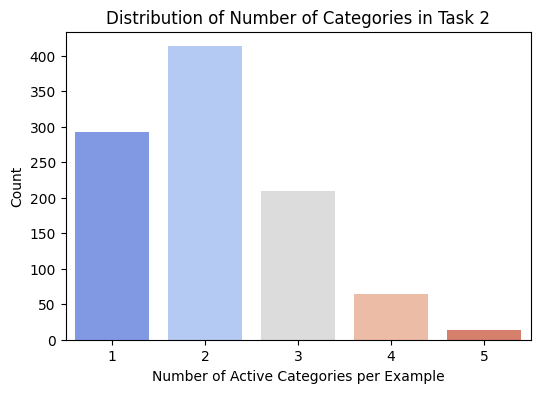

In [ ]:
#

task2_df['num_categories'] = labels_df.sum(axis=1)
print("Summary statistics for the number of categories per example:")
print(task2_df['num_categories'].describe())

plt.figure(figsize=(6,4))
sns.countplot(x=task2_df['num_categories'], palette="coolwarm")
plt.xlabel("Number of Active Categories per Example")
plt.ylabel("Count")
plt.title("Distribution of Number of Categories in Task 2")
plt.show()

## Level of PCL

Proportion of each `orig_label` in the dataset:
orig_label
0    81.492537
1     9.026866
2     1.504478
3     4.405970
4     3.570149
Name: proportion, dtype: float64


<ipython-input-23-5c65c4bf664e>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="Blues")


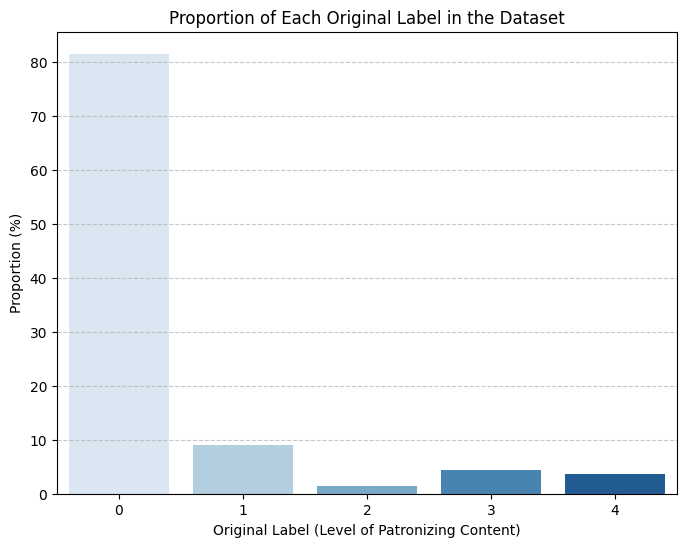

In [ ]:
def analyse_orig_label_distrbutions(dataset):
  label_counts = dataset['orig_label'].value_counts(normalize=True).sort_index()
  label_counts *= 100


  print("Proportion of each `orig_label` in the dataset:")
  print(label_counts)

  # Plot distribution
  plt.figure(figsize=(8,6))
  sns.barplot(x=label_counts.index, y=label_counts.values, palette="Blues")
  plt.xlabel("Original Label (Level of Patronizing Content)")
  plt.ylabel("Proportion (%)")
  plt.title("Proportion of Each Original Label in the Dataset")
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.show()

analyse_orig_label_distrbutions(train_df)

# Our Model
Added Features:
- Data Augmentation
- LLRD
- Ensemble models
- Weighted Random Sampling

## Modifications

### 1 - Data Augmentation

Minority class (PCL Langugage) is augmented  and the additional augmentations are added to the dataset

Majority class (Non PCL Language) is not augmented

#### Augmentation with Substitution


In [ ]:
import nlpaug.augmenter.word as naw

def augment_with_substitution(internal_train_df, model_name='distilroberta-base', augmentations=2):

    positive_examples = internal_train_df[internal_train_df['label'] == 1]
    print(f"Examples to augment: {len(positive_examples)}")

    aug = naw.ContextualWordEmbsAug(model_path=model_name, action="substitute")
    augmented_positive_examples = []

    examples_augmented = 0
    for _, row in positive_examples.iterrows():
        augmented_texts = aug.augment(row['text'], n=augmentations)
        augmented_positive_examples.extend([(row['par_id'], row['community'], text, 1) for text in augmented_texts])

        examples_augmented += 1
        if examples_augmented % 10 == 0:
            print(f"{examples_augmented} examples augmented")

    augmented_positive_df = pd.DataFrame(augmented_positive_examples, columns=['par_id', 'community', 'text', 'label'])
    augmented_positive_df = augmented_positive_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return pd.concat([internal_train_df, augmented_positive_df], ignore_index=True)

#### Augmentation with Back Translation

In [ ]:
from transformers import MarianMTModel, MarianTokenizer

def load_translation_models(src_lang="en", mid_lang="fr"):
    src_to_mid_model_name = f"Helsinki-NLP/opus-mt-{src_lang}-{mid_lang}"
    mid_to_src_model_name = f"Helsinki-NLP/opus-mt-{mid_lang}-{src_lang}"

    src_to_mid_tokenizer = MarianTokenizer.from_pretrained(src_to_mid_model_name)
    src_to_mid_model = MarianMTModel.from_pretrained(src_to_mid_model_name)

    mid_to_src_tokenizer = MarianTokenizer.from_pretrained(mid_to_src_model_name)
    mid_to_src_model = MarianMTModel.from_pretrained(mid_to_src_model_name)

    return src_to_mid_tokenizer, src_to_mid_model, mid_to_src_tokenizer, mid_to_src_model


def translate_batch(texts, tokenizer, model):

    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(**inputs)

    return [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]


def augment_with_back_translation(internal_train_df, src_lang="en", mid_lang="fr", batch_size=8):

    # Load english to french and french to english models
    src_to_mid_tokenizer, src_to_mid_model, mid_to_src_tokenizer, mid_to_src_model = load_translation_models(src_lang, mid_lang)

    src_to_mid_model.to(device)
    mid_to_src_model.to(device)

    positive_examples = internal_train_df[internal_train_df['label'] == 1]
    print(f"Examples to augment: {len(positive_examples)}")

    texts = positive_examples['text'].tolist()
    augmented_positive_examples = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        # Step 1: Translate to french
        mid_texts = translate_batch(batch_texts, src_to_mid_tokenizer, src_to_mid_model)

        # Step 2: Translate back to english
        back_translated_texts = translate_batch(mid_texts, mid_to_src_tokenizer, mid_to_src_model)

        # Append results to list
        for j, back_translated_text in enumerate(back_translated_texts):
            row = positive_examples.iloc[i + j]
            augmented_positive_examples.append((row['par_id'], row['community'], back_translated_text, 1))

        print(f"Processed {i + batch_size}/{len(texts)} samples")

    # Create DataFrame
    augmented_positive_df = pd.DataFrame(augmented_positive_examples, columns=['par_id', 'community', 'text', 'label'])
    augmented_positive_df = augmented_positive_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return pd.concat([internal_train_df, augmented_positive_df], ignore_index=True)


#### Apply Augmentations

In [ ]:
# Augment with word substitution
augmented_df_substitution = augment_with_substitution(internal_train_df)
augmented_df_substitution.to_csv("positive_augmented_substitution.csv")

# Augment with back-translation
augmented_df_back_translation = augment_with_back_translation(internal_train_df)
augmented_df_back_translation.to_csv("positive_augmented_back_translation.csv")


### 2 - Combine Augmentation with LLRD

Grouped Layer-Wise Learning Rate Decay (LLRD) optimises the learning rate in different layers to capture more diverse and fine-trained linguistic features that contribute to the meaning (PCL) with the different types of information that different layers store

In [ ]:
from transformers import DebertaForSequenceClassification, DebertaTokenizer, RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments, AdamW

num_labels = 2  # binary classification

# Load Pretrained DeBERTa model
deberta_model_name = "microsoft/deberta-base"
deberta_tokenizer = DebertaTokenizer.from_pretrained(deberta_model_name)
deberta_model = DebertaForSequenceClassification.from_pretrained(deberta_model_name, num_labels=num_labels)

# Load Pretrained DeBERTa model
roberta_model_name = "roberta-base" # or "roberta-large"
roberta_tokenizer = RobertaTokenizer.from_pretrained(roberta_model_name)
roberta_model = RobertaForSequenceClassification.from_pretrained(roberta_model_name, num_labels=num_labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/559M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def get_optimizer_grouped_parameters(model, weight_decay, base_lr, layer_decay):
    no_decay = ["bias", "LayerNorm.weight"] # Ignore these

    if hasattr(model, "roberta"):
        # ========== RoBERTa ==========
        backbone = model.roberta
        classifier = model.classifier
        encoder_layers = backbone.encoder.layer
    elif hasattr(model, "distilbert"):
        # ========== DistilBERT ==========
        backbone = model.distilbert
        classifier = model.classifier
        encoder_layers = backbone.transformer.layer  # DistilBERT has `transformer.layer`
    elif hasattr(model, "deberta"):
        backbone = model.deberta
        classifier = model.classifier
        encoder_layers = backbone.encoder.layer
    elif hasattr(model, "electra"):
        backbone = model.electra
        classifier = model.classifier
        encoder_layers = backbone.encoder.layer
    else:
        raise ValueError("Unsupported model type for LLRD. Expected RoBERTa, DeBERTa, Electra, or DistilBERT.")


    num_layers = backbone.config.num_hidden_layers

    embedding_params = list(backbone.embeddings.named_parameters())

    # Group parameters in embeddings with extra decay
    optimizer_grouped_parameters = []
    optimizer_grouped_parameters.append({
        "params": [p for n, p in embedding_params if not any(nd in n for nd in no_decay)],
        "weight_decay": weight_decay,
        "lr": base_lr * (layer_decay ** (num_layers + 1))
    })
    optimizer_grouped_parameters.append({
        "params": [p for n, p in embedding_params if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
        "lr": base_lr * (layer_decay ** (num_layers + 1))
    })

    # Group parameters in each encoder layer
    for i in range(num_layers):
        layer = encoder_layers[i]
        lr_scale = base_lr * (layer_decay ** (num_layers - i))

        layer_params = list(layer.named_parameters())
        optimizer_grouped_parameters.append({
            "params": [p for n, p in layer_params if not any(nd in n for nd in no_decay)],
            "weight_decay": weight_decay,
            "lr": lr_scale
        })
        optimizer_grouped_parameters.append({
            "params": [p for n, p in layer_params if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
            "lr": lr_scale
        })

    # Group parameters in the classifer head with base_lr
    classifer_params = list(model.classifier.named_parameters())
    optimizer_grouped_parameters.append({
        "params": [p for n, p in classifer_params if not any(nd in n for nd in no_decay)],
        "weight_decay": weight_decay,
        "lr": base_lr
    })
    optimizer_grouped_parameters.append({
        "params": [p for n, p in classifer_params if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
        "lr": base_lr
    })

    return optimizer_grouped_parameters

### 3 - Ensemble Models

In [ ]:
!pip install evaluate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.7 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import DataLoader, Dataset
import evaluate

# MARK: Ensemble Model
class RobertaDebertaEnsemble(nn.Module):
    def __init__(self, roberta_model, deberta_model):
        """
        Ensemble model that averages logits from RoBERTa and DeBERTa.

        Args:
            roberta_model (str): Hugging Face model name for RoBERTa.
            deberta_model (str): Hugging Face model name for DeBERTa.
            num_labels (int): Number of output classes.
        """
        super().__init__()
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Load models
        self.roberta = roberta_model.to(self.device)
        self.deberta = deberta_model.to(self.device)

        self.weight_logits = nn.Parameter(torch.tensor([0.5, 0.5]))

    def forward(self, roberta_inputs, deberta_inputs):
        """
        Forward pass for both models.

        Args:
            roberta_inputs (dict): Tokenized input for RoBERTa.
            deberta_inputs (dict): Tokenized input for DeBERTa.

        Returns:
            torch.Tensor: Averaged logits from both models.
        """
        roberta_logits = self.roberta(**roberta_inputs).logits
        deberta_logits = self.deberta(**deberta_inputs).logits

        # Convert raw weights into valid probabilities
        weights = F.softmax(self.weight_logits, dim=0)

        # Average logits
        ensemble_logits = weights[0] * roberta_logits + weights[1] * deberta_logits
        return ensemble_logits

# MARK: Dataset Class
class CustomDataset(Dataset):
    def __init__(self, df, tokenizer_roberta, tokenizer_deberta, max_length=512, label_column='label'):
        self.tokenized_roberta = tokenizer_roberta(
            df['text'].tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='pt'
        )
        self.tokenized_deberta = tokenizer_deberta(
            df['text'].tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='pt'
        )
        self.labels = torch.tensor(df[label_column].tolist(), dtype=torch.long)


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            {k: v[idx] for k, v in self.tokenized_roberta.items()},
            {k: v[idx] for k, v in self.tokenized_deberta.items()},
            self.labels[idx]
        )

## Model Training

In [ ]:
from torch.utils.data import WeightedRandomSampler

# MARK: Weighted sampling
def get_class_weights(df, label_column="label"):
    """ Compute class weights based on the inverse frequency of labels    """
    class_counts = df[label_column].value_counts().to_dict()  # Get class counts
    total_samples = len(df)

    # Compute inverse frequency weights
    # weights = {cls: total_samples / count for cls, count in class_counts.items()}
    max_weight = max(total_samples / np.array(list(class_counts.values())))
    weights = {cls: (total_samples / count) / max_weight for cls, count in class_counts.items()}

    # Assign a weight to each sample based on its class
    sample_weights = df[label_column].map(weights).values
    sample_weights = torch.tensor(sample_weights, dtype=torch.float)

    # Debugging
    print("\n[DEBUG] Class Counts:", class_counts)
    print("[DEBUG] Computed Weights:", weights)
    print("[DEBUG] First 10 Sample Weights:", sample_weights[:10].tolist())

    return sample_weights

# Training Function
def train_ensemble(model, train_loader, val_loader, optimizer, criterion, num_epochs=10):
    model.to(device)
    scaler = torch.amp.GradScaler("cuda")

    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_val_loss = 0.0
        preds = []
        label_counts = {0: 0, 1: 0}

        print(f"Epoch {epoch+1}/{num_epochs}")
        print("---------------------------------")

        model.train()
        for roberta_inputs, deberta_inputs, labels in train_loader:
            # Move to device
            roberta_inputs = {key: val.to(model.device) for key, val in roberta_inputs.items()}
            deberta_inputs = {key: val.to(model.device) for key, val in deberta_inputs.items()}
            labels = labels.to(model.device)

            # Zero gradients
            optimizer.zero_grad()

            with torch.amp.autocast("cuda", dtype=torch.float32):  # Mixed precision
                logits = model(roberta_inputs, deberta_inputs)
                loss = criterion(logits, labels)  # Weighted loss


            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            scaler.step(optimizer)
            scaler.update()

            total_train_loss += loss.item()

            for label in labels.cpu().numpy():
                label_counts[label] += 1


        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")

        print(f"[DEBUG] Sampled Class Distribution in Training:")
        print(f"   - Class 0 (Negative): {label_counts[0]} samples")
        print(f"   - Class 1 (Positive): {label_counts[1]} samples")


        model.eval()
        with torch.no_grad():
            for roberta_inputs, deberta_inputs, labels in val_loader:
                # Move to device
                roberta_inputs = {key: val.to(model.device) for key, val in roberta_inputs.items()}
                deberta_inputs = {key: val.to(model.device) for key, val in deberta_inputs.items()}

                labels = labels.to(model.device)

                logits = model(roberta_inputs, deberta_inputs)

                pred = torch.argmax(logits, dim=-1)

                loss = criterion(logits, labels)
                total_val_loss += loss.item()

                preds.extend(pred.cpu().tolist())

        avg_val_loss = total_val_loss / len(val_loader)
        print(f"Validation Loss: {avg_val_loss:.4f}")
        metric = evaluate.load("f1")
        print(f"F1 Score: {metric.compute(predictions=preds, references=internal_val_df.label.tolist())}")


In [ ]:
# MARK: Hyperparameters
base_lr = 5e-5
weight_decay = 0.01
layer_decay = 0.8
max_length = 512

deberta_optimizer_grouped_params = get_optimizer_grouped_parameters(deberta_model, weight_decay, base_lr, layer_decay)
roberta_model_grouped_params = get_optimizer_grouped_parameters(roberta_model, weight_decay, base_lr, layer_decay)

deberta_optimizer = AdamW(deberta_optimizer_grouped_params, lr=base_lr)
roberta_optimizer = AdamW(roberta_model_grouped_params, lr=base_lr)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
print("Using device", device)

train_weights = get_class_weights(augmented_train_set)

train_weights_np = train_weights.numpy()

print(f"[DEBUG] First 10 Training Weights: {train_weights_np[:10]}")

# Class weighted sampler
train_sampler = WeightedRandomSampler(weights=train_weights, num_samples=len(augmented_train_set[augmented_train_set['label'] == 1]), replacement=True)
# val_sampler = WeightedRandomSampler(weights=val_weights, num_samples=len(val_weights), replacement=True)

# Create dataset and dataloader
trainset = CustomDataset(augmented_train_set, roberta_tokenizer, deberta_tokenizer)
valset = CustomDataset(internal_val_df, roberta_tokenizer, deberta_tokenizer)

train_loader = DataLoader(trainset, sampler=train_sampler, batch_size=4, num_workers=2, pin_memory=True)
val_loader = DataLoader(valset, shuffle=False, batch_size=4, num_workers=2, pin_memory=True)

# Initialize model and optimizers
ensemble_model = RobertaDebertaEnsemble(roberta_model, deberta_model)

deberta_optimizer_grouped_params = get_optimizer_grouped_parameters(deberta_model, weight_decay, base_lr, layer_decay)
roberta_model_grouped_params = get_optimizer_grouped_parameters(roberta_model, weight_decay, base_lr, layer_decay)

optimizer = torch.optim.AdamW(deberta_optimizer_grouped_params + roberta_model_grouped_params, lr=base_lr)

class_weights = torch.tensor([train_weights_np[0], train_weights_np[1]], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

criterion = nn.CrossEntropyLoss()

# Train the model
train_ensemble(ensemble_model, train_loader, val_loader, optimizer, criterion, num_epochs=5)

Using device cuda

[DEBUG] Class Counts: {0: 6065, 1: 1270}
[DEBUG] Computed Weights: {0: 0.20939818631492166, 1: 1.0}
[DEBUG] First 10 Sample Weights: [0.20939818024635315, 0.20939818024635315, 0.20939818024635315, 0.20939818024635315, 0.20939818024635315, 0.20939818024635315, 0.20939818024635315, 0.20939818024635315, 0.20939818024635315, 0.20939818024635315]
[DEBUG] First 10 Training Weights: [0.20939818 0.20939818 0.20939818 0.20939818 0.20939818 0.20939818
 0.20939818 0.20939818 0.20939818 0.20939818]
Epoch 1/5
---------------------------------
Epoch [1/5], Loss: 0.4682
[DEBUG] Sampled Class Distribution in Training:
   - Class 0 (Negative): 636 samples
   - Class 1 (Positive): 634 samples
Validation Loss: 0.2516


F1 Score: {'f1': 0.39855072463768115}
Epoch 2/5
---------------------------------
Epoch [2/5], Loss: 0.3363
[DEBUG] Sampled Class Distribution in Training:
   - Class 0 (Negative): 604 samples
   - Class 1 (Positive): 666 samples
Validation Loss: 0.2510
F1 Score: {'f1': 0.5078534031413613}
Epoch 3/5
---------------------------------
Epoch [3/5], Loss: 0.3027
[DEBUG] Sampled Class Distribution in Training:
   - Class 0 (Negative): 636 samples
   - Class 1 (Positive): 634 samples
Validation Loss: 0.2573
F1 Score: {'f1': 0.5053191489361702}
Epoch 4/5
---------------------------------
Epoch [4/5], Loss: 0.2166
[DEBUG] Sampled Class Distribution in Training:
   - Class 0 (Negative): 637 samples
   - Class 1 (Positive): 633 samples
Validation Loss: 0.2593
F1 Score: {'f1': 0.532258064516129}
Epoch 5/5
---------------------------------
Epoch [5/5], Loss: 0.2350
[DEBUG] Sampled Class Distribution in Training:
   - Class 0 (Negative): 651 samples
   - Class 1 (Positive): 619 samples
Validation L

## Model Evaluation

In [ ]:
from sklearn.metrics import f1_score
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ensemble_model.to(device)

RobertaDebertaEnsemble(
  (roberta): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-11): 12 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
          

In [ ]:

def predict_texts(model, texts, tokenizer, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
            outputs = model(**inputs)

            pred = torch.argmax(outputs.logits, dim=-1).item() # binary classification
            predictions.append(pred)
    return predictions

def evaluate_f1(predictions, true_labels):
  f1 = f1_score(true_labels, predictions, pos_label=1)
  print("F1 Score (Positive Class): {:.2f}".format(f1))
  return f1

  # MARK: Predict Ensemble
def predict_ensemble(model, texts, tokenizer_roberta, tokenizer_deberta, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for text in texts:
            # Tokenize inputs for both models
            roberta_inputs = tokenizer_roberta(text, return_tensors="pt", truncation=True, padding=True).to(device)
            deberta_inputs = tokenizer_deberta(text, return_tensors="pt", truncation=True, padding=True).to(device)

            # Forward pass through the ensemble model
            outputs = model(roberta_inputs, deberta_inputs)

            # Get the predicted label
            pred = torch.argmax(outputs, dim=-1).item()  # Binary classification
            predictions.append(pred)

    return predictions


# Validation Set
# val_preds_task1, _ = model.predict(internal_val_df.text.tolist()) # Simple Transformers forward function
# val_preds_task1 = predict_texts(model, internal_val_df.text.tolist(), tokenizer, device) # Hugging Face forward function
val_preds_task1 = predict_ensemble(ensemble_model, internal_val_df.text.tolist(), roberta_tokenizer, deberta_tokenizer, device)
val_f1 = evaluate_f1(val_preds_task1, internal_val_df['label'].tolist())

# Test Set
# test_preds_task1, _ = model.predict(internal_test_df.text.tolist())
# test_preds_task1 = predict_texts(model, internal_test_df.text.tolist(), tokenizer, device)
test_preds_task1 = predict_ensemble(ensemble_model, internal_test_df.text.tolist(), roberta_tokenizer, deberta_tokenizer, device)
test_f1 = evaluate_f1(test_preds_task1, internal_test_df['label'].tolist())


model_name = "6 - Ensemble with LLRD, Augmented with back translation, Batch size = 16"
current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
results_text = (
    f"Results for {model_name}\n"
    f"Date: {current_time}\n"
    f"Validation F1 Score: {val_f1:.2f}\n"
    f"Test F1 Score: {test_f1:.2f}\n"
    "---------------------------------\n"
)

results_filename = "results.txt"
with open(results_filename, "a", encoding="utf-8") as f:
  f.write(results_text)

print(f"Results saved to {results_filename}")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


F1 Score (Positive Class): 0.51
F1 Score (Positive Class): 0.53
Results saved to results.txt


# Simple Baseline Models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

#Use Downsampling as used by baseline model
pcldf = internal_train_df[internal_train_df.label==1]
npos = len(pcldf)

trdf_ds = pd.concat([pcldf,internal_train_df[internal_train_df.label==0][:npos*2]])

## Bag of Words with Logistic Regression

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# convert text from dataframe into BoW representation
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(trdf_ds['text'])
X_test = vectorizer.transform(internal_val_df['text'])

model = LogisticRegression(random_state=0)
model.fit(X_train, trdf_ds['label'])

y_pred = model.predict(X_test)
f1 = f1_score(internal_val_df['label'], y_pred)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.3883


In [ ]:
import numpy as np

# Find indices where predictions don't match actual labels
incorrect_indices = np.where(y_pred != internal_val_df['label'].values)[0]

if len(incorrect_indices) > 0:
    # Get actual labels and predictions for incorrect examples
    actual_labels = internal_val_df.iloc[incorrect_indices]['label'].values
    predicted_labels = y_pred[incorrect_indices]

    # Count incorrect predictions for each label
    label_0_wrong = np.sum(actual_labels == 0)
    label_1_wrong = np.sum(actual_labels == 1)

    # Calculate total counts for each label in the dataset
    total_label_0 = np.sum(internal_val_df['label'] == 0)
    total_label_1 = np.sum(internal_val_df['label'] == 1)

    # Print summary of incorrect predictions
    print(f"Total incorrect predictions: {len(incorrect_indices)}")
    print(f"Label 0: {label_0_wrong} incorrect out of {total_label_0} ({label_0_wrong/total_label_0:.2%})")
    print(f"Label 1: {label_1_wrong} incorrect out of {total_label_1} ({label_1_wrong/total_label_1:.2%})")

    # Find examples where true label is 0 but predicted as 1
    pred_1_actual_0_indices = incorrect_indices[np.logical_and(actual_labels == 0, predicted_labels == 1)]

    # Find examples where true label is 1 but predicted as 0
    pred_0_actual_1_indices = incorrect_indices[np.logical_and(actual_labels == 1, predicted_labels == 0)]

    # Calculate average word count for each type of misclassification
    if len(pred_1_actual_0_indices) > 0:
        avg_words_pred_1_actual_0 = np.mean([len(internal_val_df.iloc[i]['text'].split()) for i in pred_1_actual_0_indices])
        print(f"\nAverage number of words in texts classified as 1 when true label is 0: {avg_words_pred_1_actual_0:.2f} words")
    else:
        print("\nNo examples classified as 1 when true label is 0")

    if len(pred_0_actual_1_indices) > 0:
        avg_words_pred_0_actual_1 = np.mean([len(internal_val_df.iloc[i]['text'].split()) for i in pred_0_actual_1_indices])
        print(f"Average number of words in texts classified as 0 when true label is 1: {avg_words_pred_0_actual_1:.2f} words")
    else:
        print("No examples classified as 0 when true label is 1")

    # Pick a random incorrect example
    random_idx = np.random.choice(incorrect_indices)

    # Get the example details
    example_text = internal_val_df.iloc[random_idx]['text']
    expected_label = internal_val_df.iloc[random_idx]['label']
    actual_label = y_pred[random_idx]

    print(f"\nRandom incorrect example (index {random_idx}):")
    print(f"Text: {example_text}")
    print(f"Expected label: {expected_label}")
    print(f"Predicted label: {actual_label}")
else:
    print("No incorrect predictions found!")

Total incorrect predictions: 156
Label 0: 46 incorrect out of 1516 (3.03%)
Label 1: 110 incorrect out of 159 (69.18%)

Average number of words in texts classified as 1 when true label is 0: 49.22 words
Average number of words in texts classified as 0 when true label is 1: 53.42 words

Random incorrect example (index 181):
Text: "Meanwhile , her partner in sales and mum-of-four Nita ( Angela Griffin ) is shacked up with a hopeless rogue whose "" promises are like his babies , easy to make , hard to deliver "" . And posh Pauline ( Penelope Wilton ) lives a lonely life in a big house with a husband who seems solely obsessed with his ascent through the hierarchy of the local Rotary club ."
Expected label: 0
Predicted label: 1


## Tf-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_params = {
    "min_df": 0.001,
    "ngram_range": (1, 2),
    "max_features": 10000
}

vectorizer = TfidfVectorizer(**vectorizer_params)
X_train = vectorizer.fit_transform(trdf_ds['text'])
X_test = vectorizer.transform(internal_val_df['text'])

model = LogisticRegression(max_iter=10000, random_state=0)
model.fit(X_train, trdf_ds['label'])

y_pred = model.predict(X_test)
f1 = f1_score(internal_val_df['label'], y_pred)

print(f"F1 Score: {f1:.4f}")

F1 Score: 0.3858


In [ ]:
import numpy as np

# Find indices where predictions don't match actual labels
incorrect_indices = np.where(y_pred != internal_val_df['label'].values)[0]

if len(incorrect_indices) > 0:
    # Get actual labels and predictions for incorrect examples
    actual_labels = internal_val_df.iloc[incorrect_indices]['label'].values
    predicted_labels = y_pred[incorrect_indices]

    # Count incorrect predictions for each label
    label_0_wrong = np.sum(actual_labels == 0)
    label_1_wrong = np.sum(actual_labels == 1)

    # Calculate total counts for each label in the dataset
    total_label_0 = np.sum(internal_val_df['label'] == 0)
    total_label_1 = np.sum(internal_val_df['label'] == 1)

    # Print summary of incorrect predictions
    print(f"Total incorrect predictions: {len(incorrect_indices)}")
    print(f"Label 0: {label_0_wrong} incorrect out of {total_label_0} ({label_0_wrong/total_label_0:.2%})")
    print(f"Label 1: {label_1_wrong} incorrect out of {total_label_1} ({label_1_wrong/total_label_1:.2%})")

    # Find examples where true label is 0 but predicted as 1
    pred_1_actual_0_indices = incorrect_indices[np.logical_and(actual_labels == 0, predicted_labels == 1)]

    # Find examples where true label is 1 but predicted as 0
    pred_0_actual_1_indices = incorrect_indices[np.logical_and(actual_labels == 1, predicted_labels == 0)]

    # Calculate average word count for each type of misclassification
    if len(pred_1_actual_0_indices) > 0:
        avg_words_pred_1_actual_0 = np.mean([len(internal_val_df.iloc[i]['text'].split()) for i in pred_1_actual_0_indices])
        print(f"\nAverage number of words in texts classified as 1 when true label is 0: {avg_words_pred_1_actual_0:.2f} words")
    else:
        print("\nNo examples classified as 1 when true label is 0")

    if len(pred_0_actual_1_indices) > 0:
        avg_words_pred_0_actual_1 = np.mean([len(internal_val_df.iloc[i]['text'].split()) for i in pred_0_actual_1_indices])
        print(f"Average number of words in texts classified as 0 when true label is 1: {avg_words_pred_0_actual_1:.2f} words")
    else:
        print("No examples classified as 0 when true label is 1")

    # Pick a random incorrect example
    random_idx = np.random.choice(incorrect_indices)

    # Get the example details
    example_text = internal_val_df.iloc[random_idx]['text']
    expected_label = internal_val_df.iloc[random_idx]['label']
    actual_label = y_pred[random_idx]

    print(f"\nRandom incorrect example (index {random_idx}):")
    print(f"Text: {example_text}")
    print(f"Expected label: {expected_label}")
    print(f"Predicted label: {actual_label}")
else:
    print("No incorrect predictions found!")

Total incorrect predictions: 156
Label 0: 46 incorrect out of 1516 (3.03%)
Label 1: 110 incorrect out of 159 (69.18%)

Average number of words in texts classified as 1 when true label is 0: 49.22 words
Average number of words in texts classified as 0 when true label is 1: 53.42 words

Random incorrect example (index 325):
Text: President Uhuru Kenyatta and his deputy William Ruto have been shuttling the country to ' light up ' homes especially those deep in the village where they pose with poor families .
Expected label: 1
Predicted label: 0


# Ensemble Model Analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report

Analyzing Text Length Accuracy


<ipython-input-33-cd72689f8bcb>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_by_length = df.groupby(['length_bin', 'label']).apply(lambda x: accuracy_score(x['label'], x['prediction'])).reset_index()
<ipython-input-33-cd72689f8bcb>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_by_length = df.groupby(['length_bin', 'label']).apply(lambda x: accuracy_score(x['label'], x['prediction'])).reset_index()


Overall Accuracy by Text Length (Split by Label):
        length_bin  label         0
0   (-0.001, 21.0]      0  0.907767
1   (-0.001, 21.0]      1  0.769231
2     (21.0, 27.0]      0  0.928571
3     (21.0, 27.0]      1  0.800000
4     (27.0, 32.0]      0  0.924623
5     (27.0, 32.0]      1  0.750000
6     (32.0, 37.0]      0  0.923077
7     (32.0, 37.0]      1  0.437500
8     (37.0, 41.0]      0  0.905063
9     (37.0, 41.0]      1  0.900000
10    (41.0, 47.0]      0  0.932367
11    (41.0, 47.0]      1  0.736842
12    (47.0, 54.0]      0  0.930481
13    (47.0, 54.0]      1  0.642857
14    (54.0, 65.0]      0  0.881720
15    (54.0, 65.0]      1  0.692308
16    (65.0, 81.0]      0  0.905325
17    (65.0, 81.0]      1  0.642857
18   (81.0, 272.0]      0  0.860335
19   (81.0, 272.0]      1  0.607143


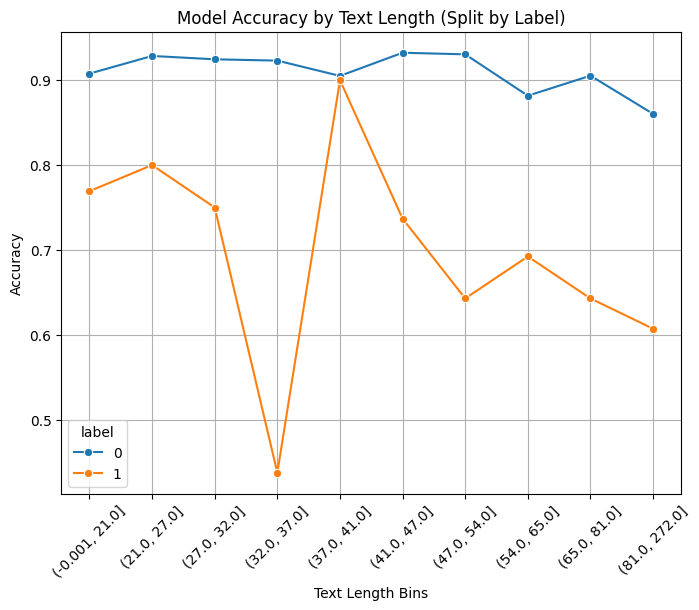

In [ ]:
def analyze_text_length_accuracy(model, df, tokenizer_roberta, tokenizer_deberta, device):
    """Analyze model accuracy across different text lengths, split by positive and negative labels."""
    # Compute text lengths
    df['text_length'] = df['text'].apply(lambda x: len(x.split()))

    # Get model predictions
    predictions = predict_ensemble(model, df['text'].tolist(), tokenizer_roberta, tokenizer_deberta, device)
    df['prediction'] = predictions

    # Compute accuracy for each text length bin, split by label
    df['length_bin'] = pd.qcut(df['text_length'], q=10, duplicates='drop')
    accuracy_by_length = df.groupby(['length_bin', 'label']).apply(lambda x: accuracy_score(x['label'], x['prediction'])).reset_index()

    # Print overall stats
    print("Overall Accuracy by Text Length (Split by Label):")
    print(accuracy_by_length)

    # Convert 'length_bin' to string for plotting
    accuracy_by_length['length_bin'] = accuracy_by_length['length_bin'].astype(str)

    # Plot accuracy vs. text length
    plt.figure(figsize=(8,6))
    sns.lineplot(data=accuracy_by_length, x='length_bin', y=0, hue='label', marker='o')
    plt.xlabel("Text Length Bins")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy by Text Length (Split by Label)")
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

print("Analyzing Text Length Accuracy")
analyze_text_length_accuracy(ensemble_model, internal_test_df, roberta_tokenizer, deberta_tokenizer, device)


Analyzing Keyword Accuracy


<ipython-input-36-586f5e106393>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  keyword_accuracy = df.groupby(['community', 'label']).apply(lambda x: accuracy_score(x['label'], x['prediction'])).reset_index()


Overall Accuracy by Community (Split by Label):
        community  label         0
0        disabled      0  0.877778
1        disabled      1  0.500000
2        homeless      0  0.863388
3        homeless      1  0.724138
4        hopeless      0  0.879581
5        hopeless      1  0.576923
6       immigrant      0  0.985782
7       immigrant      1  0.428571
8         in-need      0  0.886010
9         in-need      1  1.000000
10        migrant      0  0.975248
11        migrant      1  0.600000
12  poor-families      0  0.868421
13  poor-families      1  0.552632
14        refugee      0  0.885714
15        refugee      1  0.846154
16     vulnerable      0  0.920635
17     vulnerable      1  0.650000
18          women      0  0.936073
19          women      1  0.785714


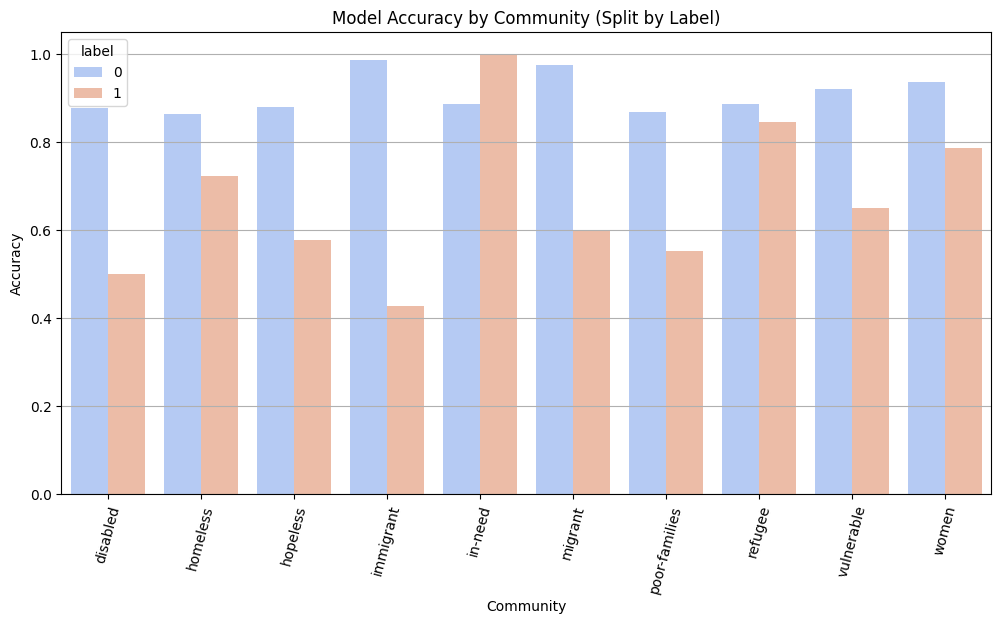

In [ ]:
def analyze_keyword_accuracy(model, df, tokenizer_roberta, tokenizer_deberta, device):
    """Analyze model accuracy per community/keyword, split by positive and negative labels."""
    # Get model predictions
    predictions = predict_ensemble(model, df['text'].tolist(), tokenizer_roberta, tokenizer_deberta, device)
    df['prediction'] = predictions

    # Compute accuracy per keyword, split by label
    keyword_accuracy = df.groupby(['community', 'label']).apply(lambda x: accuracy_score(x['label'], x['prediction'])).reset_index()

    # Print overall stats
    print("Overall Accuracy by Community (Split by Label):")
    print(keyword_accuracy)

    # Convert 'keyword' to string for plotting
    keyword_accuracy['community'] = keyword_accuracy['community'].astype(str)

    # Plot accuracy per keyword
    plt.figure(figsize=(12,6))
    sns.barplot(data=keyword_accuracy, x='community', y=0, hue='label', palette='coolwarm')
    plt.xlabel("Community")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy by Community (Split by Label)")
    plt.xticks(rotation=75)
    plt.grid(axis='y')
    plt.show()

print("Analyzing Keyword Accuracy")
analyze_keyword_accuracy(ensemble_model, internal_test_df, roberta_tokenizer, deberta_tokenizer, device)


<ipython-input-32-d6451c1b92ed>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  orig_label_accuracy = df.groupby(['orig_label', 'label']).apply(lambda x: accuracy_score(x['label'], x['prediction'])).reset_index()


Overall Accuracy by Level of Patronizing Content (Split by Label):
  orig_label  label         0
0          0      0  0.936620
1          1      0  0.670157
2          2      1  0.222222
3          3      1  0.595506
4          4      1  0.826087


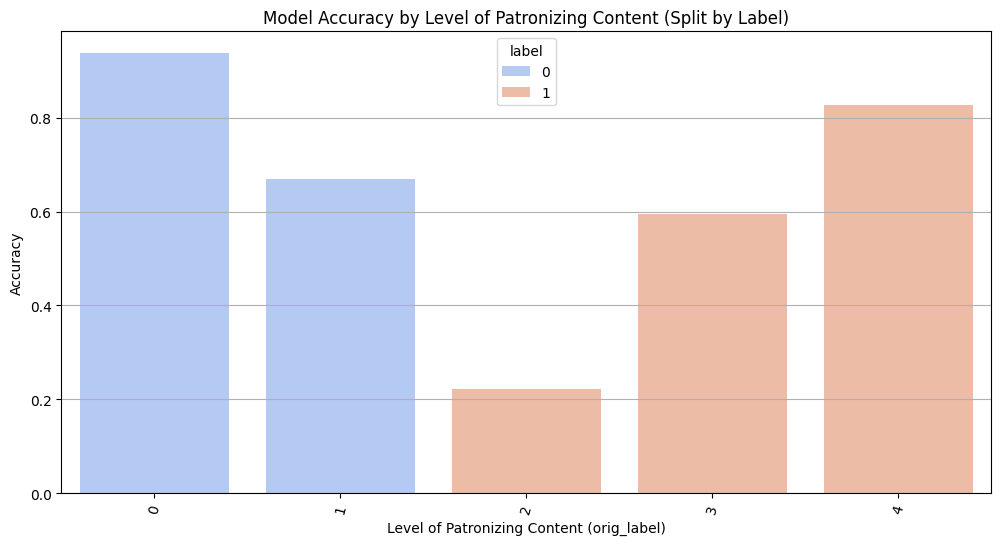

In [ ]:
def analyze_original_label_accuracy(model, df, tokenizer_roberta, tokenizer_deberta, device):
  """Model accuracy per level of patronizing content"""

  predictions = predict_ensemble(model, df['text'].tolist(), tokenizer_roberta, tokenizer_deberta, device)
  df['prediction'] = predictions

  # Compute accuracy per orig_label, split by label
  orig_label_accuracy = df.groupby(['orig_label', 'label']).apply(lambda x: accuracy_score(x['label'], x['prediction'])).reset_index()

  # Print overall stats
  print("Overall Accuracy by Level of Patronizing Content (Split by Label):")
  print(orig_label_accuracy)

  # Convert 'orig_label' to string for plotting
  orig_label_accuracy['orig_label'] = orig_label_accuracy['orig_label'].astype(str)

  # Plot accuracy per orig_label
  plt.figure(figsize=(12,6))
  sns.barplot(data=orig_label_accuracy, x='orig_label', y=0, hue='label', palette='coolwarm')
  plt.xlabel("Level of Patronizing Content (orig_label)")
  plt.ylabel("Accuracy")
  plt.title("Model Accuracy by Level of Patronizing Content (Split by Label)")
  plt.xticks(rotation=75)
  plt.grid(axis='y')
  plt.show()


analyze_original_label_accuracy(ensemble_model, internal_test_df, roberta_tokenizer, deberta_tokenizer, device)


# Test and Dev set predictions

In [ ]:
# Save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pr in p:
			outf.write(str(pr)+'\n')

## Official Test Set Predictions

In [ ]:
test_set_predictions = predict_ensemble(ensemble_model, official_test_df['text'].tolist(), roberta_tokenizer, deberta_tokenizer, device)
labels2file(test_set_predictions, "test.txt")

## Official Dev Set Predictions

In [ ]:
dev_set_predictions = predict_ensemble(ensemble_model, internal_test_df['text'].tolist(), roberta_tokenizer, deberta_tokenizer, device)
labels2file(dev_set_predictions, "dev.txt")